      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides   
0               7.4             0.700         0.00             1.9      0.076  \
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1138            6.3             0.510         0.13             2.3      0.076   
1139            6.8             0.620         0.08             1.9      0.068   
1140            6.2             0.600         0.08             2.0      0.090   
1141            5.9             0.550         0.10             2.2      0.062   
1142            5.9             0.645         0.12             2.0      0.075   

      free sulfur dioxide  

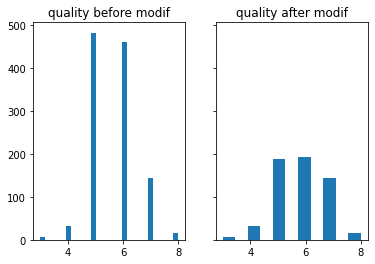

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('WineQT.csv')
print(df)
import numpy as np
import matplotlib.pyplot as plt
# load the dataset

y_train = df['quality']
X_train= [df['volatile acidity'],df['alcohol'],df['sulphates'],df['citric acid']]
X_features = ['volatile acidity','alcohol','sulphates','citric acid']
X_train=np.transpose(np.asmatrix(X_train))
y_train=np.asarray(y_train)


def zscore_normalize_features(X):
    mu     = np.mean(X, axis=0)                 # mu will have shape (n,)
    # find the standard deviation of each column/feature
    sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - mu) / sigma      

    return (X_norm, mu, sigma)

X_norm, X_mu, X_sigma = zscore_normalize_features(X_train)
print(X_norm)
import random
fig,ax=plt.subplots(1,2,sharey=True)
ax[0].hist(df["quality"], bins='auto',label="quality")
ax[0].set_title("quality before modif")
supp=[]
#on supprime aleatoirement des valeurs de notes 5 et 6 (diviser par 3)
for i in range(len(y_train)):
    if y_train[i]==5 or y_train[i]==6:
        rand=random.random()
        if(rand>0.4):
            supp.append(i)
for j in range(len(supp)):
    y_train2=np.delete(y_train,supp)
    X_norm2=np.delete(X_norm,supp,0)


ax[1].hist(y_train2, bins='auto',label="quality")
ax[1].set_title("quality after modif")

print(y_train2)
print(X_norm2)

#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test =train_test_split(wine_df.drop('quality',axis=1), wine_df['quality'], test_size=.3,
 #                                                  random_state=22)
#X_train.shape,X_test.shape

In [6]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Args:
        z (ndarray): A scalar, numpy array of any size.

    Returns:
        g (ndarray): sigmoid(z), with the same shape as z
         
    """

    g = 1/(1+np.exp(-z))
   
    return g

In [76]:
import copy
import math


def compute_cost_softmax(X, y, W, B):
    m, n = X.shape
    #print("n",n)
    nb_f=W.shape[0]
    #print("nf",nb_f)
   ### START CODE HERE ###
    loss_sum = 0 

    
  # on calcule tous les zj=fwb
   # Loop over each training example
    for i in range(m): 
      f_WB=np.zeros(nb_f)
      # Loop over each class
      for loop in range(nb_f):
        z_wb = 0 
       # Loop over each feature
        for j in range(n): 

             z_wb_ij = W[loop,j]*X[i,j]
             z_wb += z_wb_ij 
        z_wb += B[loop] 

        f_WB[loop] = sigmoid(z_wb)#=e(Zij), #à diviser par sumezi pour avoir probabilité que y==loop

      sumEzi=sum(f_WB)
      
      loss_sum += np.log(f_WB[y[i]]/sumEzi) # on ajoute -log(a_i) if y=i

    total_cost = -(1 / m) * loss_sum  

    return total_cost


def compute_gradient_softmax(X, y, W, B): 


    m, n = X.shape
    nb_f=W.shape[0]

    dJ_DW = np.zeros((nb_f,n))                           #(n,)
    dJ_DB = np.zeros((nb_f))

    for i in range(m): 
      f_WB=np.zeros(nb_f)
      # Loop over each class
      for loop in range(nb_f):
        z_wb = 0 
       # Loop over each feature
        for j in range(n): 

             z_wb_ij = W[loop,j]*X[i,j]
             z_wb += z_wb_ij 
        z_wb += B[loop] 

        f_WB[loop] = sigmoid(z_wb)#=e(Zij)

      sumEzi=sum(f_WB) 
      f_WB=f_WB/sumEzi # tableau des probabilité que y==loop

      #print("somme des f_WB : ",sum(f_WB))
      #on calcule la dérivé
      for loop in range(nb_f):
        err_loop  = f_WB[loop]  - (y[loop]==y[i])         #scalar, proba que y = loop  - (1 ou 0)(si y ==loop)
        for j in range(n):
            dJ_DW[loop,j] = dJ_DW[loop,j] + err_loop * X[i,j]      #scalar
        dJ_DB[loop] = dJ_DB[loop] + err_loop
      dJ_DW = dJ_DW/m                                   #(n,)
      dJ_DB = dJ_DB/m                                   #scalar
        
    return dJ_DB, dJ_DW 

def gradient_descent_softmax(X, y, W_in, B_in, alpha, num_iters): 

    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    W = copy.deepcopy(W_in)  #avoid modifying global w within function
    B = B_in
    m, n = X.shape
    nb_f=W.shape[0]
    
    for i in range(num_iters):
        # Calculate the gradient and update the parameters
        dJ_DB, dJ_DW = compute_gradient_softmax(X, y, W, B)   

        # Update Parameters using w, b, alpha and gradient
        W = W - alpha * dJ_DW               
        B = B - alpha * dJ_DB               
      
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( compute_cost_softmax(X, y, W, B) )

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            
            print(f"Iteration {i:4d}: Cost {J_history[-1]}   ")
            print("W : ",W," B : ",B)
            #x_test = X_train[50]   # example
            #print(x_test)
            #tabProbas=np.dot(W,x_test)+B
            #print(tabProbas)
            
    return W, B, J_history         #return final w,b and J history for graphing 

In [7]:
def map_feature(X1, X2):
    X1 = np.atleast_1d(X1)
    X2 = np.atleast_1d(X2)
    degree = 6
    out = []
    for i in range(1, degree+1):
        for j in range(i + 1):
            out.append((X1**(i-j) * (X2**j)))
    return np.stack(out, axis=1)

test cout

In [72]:
#[df['volatile acidity'],df['alcohol'],df['sulphates'],df['citric acid']]
X_train=np.copy(X_norm2)
y_train=np.copy(y_train2)
nbClasses=9
print(X_train.shape[1])

np.random.seed(1)
initial_W = np.random.rand(nbClasses,X_train.shape[1]) - 0.5
print(initial_W)
initial_B = np.ones(nbClasses)*0.5
print(initial_B)
cost = compute_cost_softmax(X_train, y_train, initial_W, initial_B)

print(" cost :", cost)

4
[[-0.082978    0.22032449 -0.49988563 -0.19766743]
 [-0.35324411 -0.40766141 -0.31373979 -0.15443927]
 [-0.10323253  0.03881673 -0.08080549  0.1852195 ]
 [-0.29554775  0.37811744 -0.47261241  0.17046751]
 [-0.0826952   0.05868983 -0.35961306 -0.30189851]
 [ 0.30074457  0.46826158 -0.18657582  0.19232262]
 [ 0.37638915  0.39460666 -0.41495579 -0.46094522]
 [-0.33016958  0.3781425  -0.40165317 -0.07889237]
 [ 0.45788953  0.03316528  0.19187711 -0.18448437]]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
 cost : 2.2211481414984697


test gradient

In [73]:
print(X_train)

np.random.seed(1)
initial_W = np.random.rand(nbClasses,X_train.shape[1]) - 0.5
print("initial_W :\n",initial_W)
initial_B = np.ones(nbClasses)*0.5
print(initial_B)
 
lambda_ = 0.5
dJ_DB, dJ_DW = compute_gradient_softmax(X_train, y_train, initial_W, initial_B)

print(f"dj_db: {dJ_DB}", )
print(f"First few elements of dj_dw:\n {dJ_DW}", )

[[ 0.71655875 -0.96338181 -0.57365783 -1.36502663]
 [ 0.66086539 -0.4087107  -1.10206203 -1.36502663]
 [ 0.27101182 -0.87093663 -0.51494625 -1.26329712]
 ...
 [-0.11884175  0.51574115  0.54186214 -0.70378484]
 [ 0.38239855  0.05351522 -0.45623467 -0.9581086 ]
 [ 0.6330187  -0.22382033  0.30701583 -0.75464959]]
initial_W :
 [[-0.082978    0.22032449 -0.49988563 -0.19766743]
 [-0.35324411 -0.40766141 -0.31373979 -0.15443927]
 [-0.10323253  0.03881673 -0.08080549  0.1852195 ]
 [-0.29554775  0.37811744 -0.47261241  0.17046751]
 [-0.0826952   0.05868983 -0.35961306 -0.30189851]
 [ 0.30074457  0.46826158 -0.18657582  0.19232262]
 [ 0.37638915  0.39460666 -0.41495579 -0.46094522]
 [-0.33016958  0.3781425  -0.40165317 -0.07889237]
 [ 0.45788953  0.03316528  0.19187711 -0.18448437]]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
somme des f_WB :  0.9999999999999999
somme des f_WB :  0.9999999999999999
somme des f_WB :  0.9999999999999998
somme des f_WB :  0.9999999999999998
somme des f_WB :  1.0
somme d

GRADIENT DESCENT APPLICATION

In [75]:
np.random.seed(1)
initial_W = np.random.rand(nbClasses,X_train.shape[1]) - 0.5
print("initial_W :\n",initial_W)
initial_B = np.ones(nbClasses)*0.5
print(initial_B)

# Some gradient descent settings
iterations = 1000
alpha = 0.1

W,B, J_history = gradient_descent_softmax(X_train, y_train, initial_W, initial_B, alpha, iterations)

initial_W :
 [[-0.082978    0.22032449 -0.49988563 -0.19766743]
 [-0.35324411 -0.40766141 -0.31373979 -0.15443927]
 [-0.10323253  0.03881673 -0.08080549  0.1852195 ]
 [-0.29554775  0.37811744 -0.47261241  0.17046751]
 [-0.0826952   0.05868983 -0.35961306 -0.30189851]
 [ 0.30074457  0.46826158 -0.18657582  0.19232262]
 [ 0.37638915  0.39460666 -0.41495579 -0.46094522]
 [-0.33016958  0.3781425  -0.40165317 -0.07889237]
 [ 0.45788953  0.03316528  0.19187711 -0.18448437]]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
somme des f_WB :  0.9999999999999999
somme des f_WB :  0.9999999999999999
somme des f_WB :  0.9999999999999998
somme des f_WB :  0.9999999999999998
somme des f_WB :  1.0
somme des f_WB :  0.9999999999999999
somme des f_WB :  1.0000000000000002
somme des f_WB :  1.0
somme des f_WB :  0.9999999999999999
somme des f_WB :  1.0
somme des f_WB :  1.0
somme des f_WB :  1.0
somme des f_WB :  0.9999999999999998
somme des f_WB :  1.0
somme des f_WB :  0.9999999999999999
somme des f_WB :  1.0
so

KeyboardInterrupt: 

test du résultat

In [80]:
def locateMax(tab):
    max=0
    for loop in range(len(tab)):
        if tab[loop]>tab[max]:
            max=loop
    return max

In [81]:
x_test = X_train[50]   # negative example
print(x_test)

tabProbas=np.dot(W,x_test)+B
tabProbas=sigmoid(tabProbas)
tabProbas=tabProbas/sum(tabProbas)
print(sum(tabProbas))
print(tabProbas)

print("largest value", np.max(tabProbas), "smallest value", np.min(tabProbas))
print("position du max : ",locateMax(tabProbas))

[ 0.38239855 -0.31626552 -0.69108098 -1.21243237]
0.9999999999999999
[0.12549339 0.1124433  0.08971991 0.10696418 0.12756815 0.09290582
 0.13455841 0.10307761 0.10726921]
largest value 0.13455841479697814 smallest value 0.0897199130466087
position du max :  6
